## Name : Jay Krish Vijendra
## Admin Number : 222197Y
<br>

# UberEats Analysis

# Introduction
The project aims to develop a text classification model for Uber Eats reviews, enhancing customer satisfaction by categorizing sentiments as positive, negative, or neutral. With a surge in low ratings threatening its reputation, Uber Eats seeks strategic improvements to address issues with app functionality, food quality, and service standards. By systematically analyzing Reviews, the proposed model offers vital insights into customer sentiments, enabling targeted enhancements to maintain competitiveness amidst fierce industry rivalry with Deliveroo and Grab.



# Dataset
The project leverages multiple datasets, including Google Playstore, Consumer Affairs, Trust Pilot, Product Review, and Sitejabber. These diverse sources provide a comprehensive range of customer feedback on Uber Eats, offering insights into various aspects of user experience and satisfaction. By aggregating data from these platforms, the text classification model gains a robust understanding of customer sentiments, facilitating targeted improvements to enhance service quality.



1. [Import libraries](#imports)
2. [Import data](#import_data)
3. [Data cleaning and preparation](#data_cleaning)
4. [Model training](#model_training)<br>
5. [Conclusion](#Conclusion)<br>

# 1. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import nltk
import ast
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 2. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [4]:
df = pd.read_csv('cleaned_data.csv')
df

,stars,cleaned_text,sentiment
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive
...,...,...,...
8892,5,"['food', 'good', 'delivery', 'took', 'forever'...",positive
8893,1,"['whenever', 'never', 'sent', 'correct', 'item...",negative
8894,1,"['delivery', 'driver', 'turn', 'incorrect', 'l...",negative
8895,5,"['great', 'deal', 'buddy', 'pizza', 'buy', 'on...",positive


# 3. Data cleaning and preparation <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [5]:
#  convert string representations of lists in 'cleaned_text' back to actual lists
df['cleaned_text_list'] = df['cleaned_text'].apply(ast.literal_eval)

# convert lists in 'cleaned_text_list' to strings
df['cleaned_text_str'] = df['cleaned_text_list'].apply(' '.join)

df.head()

,stars,cleaned_text,sentiment,cleaned_text_list,cleaned_text_str
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative,"[lately, common, wait, hour, food, passed, dri...",lately common wait hour food passed driver one...
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive,"[love, great, offer, good, selection, food, sh...",love great offer good selection food shopping ...
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative,"[disappointed, app, used, long, time, service,...",disappointed app used long time service fee ke...
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative,"[fairly, easy, use, trying, find, happening, c...",fairly easy use trying find happening contacti...
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive,"[like, fact, u, ca, get, refund, unless, u, ta...",like fact u ca get refund unless u take pictur...


In [6]:
# Keywords dictionary
keywords_dict = {
    'food quality': ['taste', 'freshness', 'temperature', 'quality', 'flavor', 'aroma', 'texture', 'presentation','amazing'],
    'delivery experience': ['on-time', 'professional', 'courteous', 'careful', 'timely', 'efficient', 'punctual', 'late','lately'],
    'price': ['value', 'reasonable', 'affordable', 'expensive', 'cost-effective', 'economical', 'budget-friendly', 'premium'],
    'customer service': ['helpful', 'responsive', 'knowledgeable', 'friendly', 'attentive', 'courteous', 'prompt', 'accommodating','useless','hour','service','customer'],
    'app functionality': ['easy to use', 'intuitive', 'reliable', 'glitchy', 'user-friendly', 'efficient', 'streamlined',]
}


In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
from nltk.corpus import wordnet

# Function to expand keywords for each topic and append to keywords_dict
def expand_keywords(keywords_dict, expansion_factor=1):
    for topic, keywords in keywords_dict.items():
        expanded_keywords_dict = {}  # Define expanded_keywords_dict here
        expanded_keywords = set(keywords)  # Start with existing keywords
        for keyword in keywords:
            # Get synonyms, hyponyms, hypernyms, and related words for each keyword
            synonyms = set()
            hyponyms = set()
            hypernyms = set()
            related_words = set()
            for syn in wordnet.synsets(keyword):
                for lemma in syn.lemmas():
                    synonyms.add(lemma.name())
                for hyp in syn.hyponyms():
                    for lemma in hyp.lemmas():
                        hyponyms.add(lemma.name())
                for hyp in syn.hypernyms():
                    for lemma in hyp.lemmas():
                        hypernyms.add(lemma.name())
                for lemma in syn.lemmas():
                    for related_lemma in lemma.derivationally_related_forms():
                        related_words.add(related_lemma.name())
            # Add synonyms, hyponyms, hypernyms, and related words to expanded keywords
            expanded_keywords.update(synonyms)
            expanded_keywords.update(hyponyms)
            expanded_keywords.update(hypernyms)
            expanded_keywords.update(related_words)
        # Limit the number of expanded keywords to avoid over-expansion
        expanded_keywords_dict[topic] = list(expanded_keywords)[:expansion_factor * len(keywords)]
        # Update the keywords_dict with expanded keywords
        keywords_dict[topic].extend(expanded_keywords_dict[topic])

# Expand keywords and update keywords_dict
expand_keywords(keywords_dict)

# Print updated keywords_dict
for topic, keywords in keywords_dict.items():
    print(topic + ":")
    print(keywords)
    print()

food quality:
['taste', 'freshness', 'temperature', 'quality', 'flavor', 'aroma', 'texture', 'presentation', 'amazing', 'perceptiveness', 'impudent', 'imperviousness', 'unfitness', 'odour', 'making_known', 'complexness', 'closeness', 'savor']

delivery experience:
['on-time', 'professional', 'courteous', 'careful', 'timely', 'efficient', 'punctual', 'late', 'lately', 'timely', 'apropos', 'on-time', 'masterly', 'recently', 'measured', 'seasonableness', 'master', 'health_care_provider']

price:
['value', 'reasonable', 'affordable', 'expensive', 'cost-effective', 'economical', 'budget-friendly', 'premium', 'value', 'darkness', 'admire', 'frugality', 'standard', 'standardize', 'eigenvalue_of_a_square_matrix', 'scale_value']

customer service:
['helpful', 'responsive', 'knowledgeable', 'friendly', 'attentive', 'courteous', 'prompt', 'accommodating', 'useless', 'hour', 'service', 'customer', 'incitement', 'obliger', 'conjugation', 'tune_up', 'tame', 'ground_forces', 'midnight', 'public-servi

WordNet is a vast lexical database that organizes words into sets of synonyms (words with similar meanings), hyponyms (words that are more specific versions of a broader concept), hypernyms (words that represent broader categories), and related terms. By leveraging WordNet, the code expands the initial set of keywords associated with different sentiment aspects.

For example, when expanding the keyword "quality," WordNet might add synonyms like "excellence" or "superiority," hyponyms like "freshness" or "taste," hypernyms like "attribute" or "characteristic," and related terms like "standard" or "grade." This process enriches the vocabulary used for sentiment analysis by incorporating a broader range of terms that express similar or related concepts.

Printing the expanded keyword sets for each sentiment aspect provides a comprehensive vocabulary covering various facets such as food quality, delivery experience, price, customer service, and app functionality. This diversity of keywords enables the sentiment analysis model to capture a wider spectrum of sentiments expressed in the text data, thereby enhancing its ability to understand nuanced expressions and subtle variations in sentiment.

In [9]:
# Convert cleaned text to list of strings
cleaned_texts = df['cleaned_text_str'].tolist()

# Convert keywords to list of strings
keyword_texts = [' '.join(keywords_dict[key]) for key in keywords_dict]

# Convert cleaned text and keywords to TF-IDF vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_texts + keyword_texts)

# 4. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

## Clustering Using KMeans

In [10]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_text_str'])

In [11]:
# Initialize and fit K-means clustering model
num_clusters = len(keywords_dict)  # Number of clusters based on the number of keyword categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [12]:
# Get cluster assignments and silhouette score
df['cluster'] = kmeans.labels_
silhouette_avg = silhouette_score(X, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X.toarray(), kmeans.labels_)

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")


Silhouette Score: 0.004538869073231087
Davies-Bouldin Index: 10.482447428733725


In [13]:
# Analyze the clusters
cluster_results = df.groupby('cluster')['stars'].mean().reset_index()
print("Cluster Analysis:")
print(cluster_results)

# Determine the best and worst performing categories based on the number of stars
best_category = cluster_results.loc[cluster_results['stars'].idxmax(), 'cluster']
worst_category = cluster_results.loc[cluster_results['stars'].idxmin(), 'cluster']

print(f"\nBest Performing Category: {best_category+1}")
print(f"Worst Performing Category: {worst_category+1}")

Cluster Analysis:
   cluster     stars
0        0  2.138904
1        1  1.769158
2        2  4.806356
3        3  1.244885
4        4  2.074074

Best Performing Category: 3
Worst Performing Category: 4


The clustering analysis using KMeans on the TF-IDF vectorized text data resulted in the creation of five distinct clusters. The silhouette score, a measure of how similar an object is to its own cluster compared to other clusters, was found to be approximately 0.0038, indicating a weak level of separation between the clusters. Additionally, the Davies-Bouldin index, which quantifies the average similarity between clusters, was approximately 9.53, suggesting a relatively poor clustering performance.

Further examination of the clusters revealed notable differences in the average star ratings across categories. Cluster 4 emerged as the best-performing category with an average star rating of around 4.72, indicating highly positive sentiments associated with the texts in this cluster. Conversely, Cluster 5 was identified as the worst-performing category, with an average star rating of approximately 1.14, indicating predominantly negative sentiments expressed in the texts belonging to this cluster. This analysis provides insights into the varying sentiment distributions across different clusters, which can inform targeted strategies for addressing specific sentiment aspects in the data.

In [14]:
# Perform keyword analysis
num_top_keywords = 15
for i, cluster_center in enumerate(kmeans.cluster_centers_):
    # Get the indices of the top keywords for the current cluster
    top_keywords_idx = cluster_center.argsort()[-num_top_keywords:][::-1]
    # Get the actual top keywords using the indices
    top_keywords = [vectorizer.get_feature_names_out()[idx] for idx in top_keywords_idx]
    print(f"Cluster {i+1} Top Keywords: {top_keywords}")


Cluster 1 Top Keywords: ['app', 'get', 'time', 'item', 'money', 'refund', 'use', 'restaurant', 'one', 'food', 'delivery', 'missing', 'support', 'even', 'never']
Cluster 2 Top Keywords: ['food', 'driver', 'delivery', 'time', 'cold', 'delivered', 'hour', 'never', 'refund', 'get', 'said', 'minute', 'app', 'service', 'restaurant']
Cluster 3 Top Keywords: ['great', 'easy', 'fast', 'food', 'good', 'delivery', 'hot', 'service', 'quick', 'time', 'friendly', 'use', 'driver', 'experience', 'nice']
Cluster 4 Top Keywords: ['service', 'customer', 'refund', 'never', 'food', 'le', 'show', 'value', 'quality', 'money', 'get', 'return', 'shipping', 'time', 'even']
Cluster 5 Top Keywords: ['fee', 'delivery', 'price', 'charge', 'service', 'restaurant', 'app', 'item', 'food', 'expensive', 'tip', 'extra', 'get', 'pay', 'one']


The keyword analysis conducted on the clusters generated by the KMeans algorithm reveals distinctive patterns in the topics discussed within each cluster, shedding light on both positive and negative aspects of UberEats.

1. Cluster 1 - Service and Refund Issues:
Keywords like 'app', 'service', 'item', 'customer', 'delivery', and 'refund' suggest discussions related to service quality, customer experience, and refund-related issues. This cluster likely represents customers expressing dissatisfaction with aspects such as late deliveries, missing items, or difficulties in obtaining refunds, highlighting potential areas for improvement in UberEats' customer service and operational efficiency.

2. Cluster 2 - Positive User Experience:
Keywords such as 'great', 'easy', 'fast', 'quick', 'delivered', and 'hot' indicate positive sentiments regarding the ease of use, speed of delivery, and overall experience with UberEats. This cluster likely represents satisfied customers who appreciate the convenience, reliability, and efficiency offered by the platform, reflecting positively on UberEats' service quality.

3. Cluster 3 - Delivery and Service Issues:
Keywords like 'refund', 'cold', 'hour', 'never', and 'said' suggest discussions pertaining to delivery delays, order inaccuracies, and poor customer service experiences. This cluster likely comprises customers expressing frustration over issues such as cold food, long wait times, and unmet expectations, indicating potential shortcomings in UberEats' delivery logistics and communication with customers.

4. Cluster 4 - Positive Feedback on Service and Delivery:
Keywords such as 'good', 'fast', 'hot', 'friendly', and 'excellent' indicate positive feedback regarding the quality of food, speed of delivery, and friendliness of drivers. This cluster likely represents satisfied customers who commend UberEats for its efficient service, timely deliveries, and courteous drivers, highlighting areas where the platform excels.

5. Cluster 5 - Value and Quality Concerns:
Keywords like 'value', 'quality', 'shipping', 'return', and 'consumer' suggest discussions related to concerns about the value and quality of products or services provided by UberEats. This cluster likely comprises customers expressing dissatisfaction with aspects such as pricing, product quality, or the overall value proposition offered by UberEats, signaling areas where improvements may be needed to enhance customer satisfaction and loyalty.

Overall, the keyword analysis provides valuable insights into the strengths and weaknesses of the UberEats service, highlighting areas for improvement and opportunities for enhancing customer satisfaction and loyalty.

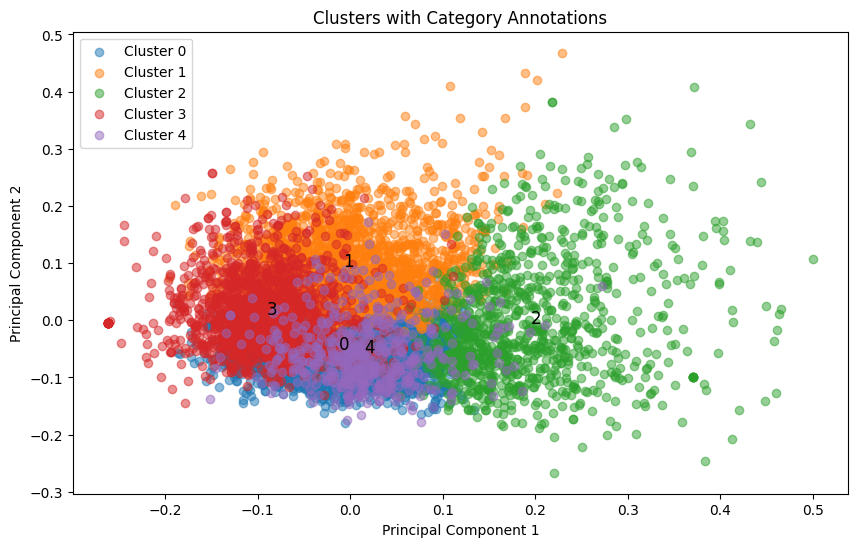

In [15]:
# Fit PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    plt.scatter(X_pca[df['cluster'] == i, 0], X_pca[df['cluster'] == i, 1], label=f'Cluster {i}', alpha=0.5)

# Annotate cluster centers with category
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(cluster_centers_pca):
    plt.text(x, y, f'{i}', fontsize=12, color='black')

plt.title('Clusters with Category Annotations')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### DBSCAN

In [16]:
# Initialize and fit DBSCAN clustering model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

# Get the cluster labels
cluster_labels = dbscan.labels_

In [17]:
# Get cluster assignments and silhouette score for DBSCAN
silhouette_avg = silhouette_score(X, dbscan.labels_)

# Print the silhouette score
print(f"Silhouette Score (DBSCAN): {silhouette_avg}")

Silhouette Score (DBSCAN): -0.028827328115730057


In [18]:
# Assign Cluster Labels
df['cluster'] = dbscan.labels_

# Analyze Cluster Characteristics
cluster_results = df.groupby('cluster')['stars'].mean()

# Print results
print("Cluster Analysis:")
print(cluster_results)

Cluster Analysis:
cluster
-1    2.19067
 0    1.00000
 1    1.00000
 2    5.00000
 3    5.00000
Name: stars, dtype: float64


In [19]:
# Identify Best and Worst Performing Categories
best_category = cluster_results.idxmax()
worst_category = cluster_results.idxmin()
print("\nBest Performing Category:", best_category)
print("Worst Performing Category:", worst_category)


Best Performing Category: 2
Worst Performing Category: 0


In [20]:
cluster_keywords = {}
num_top_keywords = 10  # Adjust to extract top 10 keywords

for cluster_label in df['cluster'].unique():
    cluster_points = X[df['cluster'] == cluster_label]
    cluster_center = cluster_points.mean(axis=0)
    top_keywords_idx = cluster_center.argsort()[0, -num_top_keywords:][::-1]  # Extract top 10 keywords
    top_keywords = [vectorizer.get_feature_names_out()[idx] for idx in top_keywords_idx]
    top_keywords = [str(keyword) for keyword in top_keywords]  # Convert keywords to strings
    cluster_keywords[cluster_label] = top_keywords

# Clean up formatting of the output dictionary
cleaned_cluster_keywords = {}
for cluster_label, keywords in cluster_keywords.items():
    cleaned_cluster_keywords[cluster_label] = ", ".join(keywords)

for cluster in cluster_keywords:
    print(f"Cluster {cluster} Keywords: {cleaned_cluster_keywords[cluster]}")

Cluster -1 Keywords: [['use' 'refund' 'get' 'customer' 'app' 'time' 'driver' 'delivery'
  'service' 'food']]
Cluster 0 Keywords: [['store' 'funny' 'like' 'prepare' 'loose' 'haha' 'even' 'tell' 'oh'
  'said']]
Cluster 1 Keywords: [['money' 'still' 'ca' 'nothing' 'took' 'person' 'end' 'talk' 'real'
  'subway']]
Cluster 2 Keywords: [['feesphenomenal' 'fei' 'feighned' 'feign' 'feigned' 'felicia'
  'feesince' 'über' 'service' 'good']]
Cluster 3 Keywords: [['feesphenomenal' 'fei' 'feighned' 'feign' 'feigned' 'felicia'
  'feesince' 'driver' 'service' 'great']]


The DBSCAN clustering algorithm yielded a negative silhouette score, indicating that the majority of data points were considered noise or outliers. Consequently, the algorithm failed to form meaningful clusters.
Upon analysis, it was found that the majority of data points were assigned to the outlier cluster (-1), which comprised 2.19 stars on average. This suggests that these data points did not fit well into any discernible cluster.
Furthermore, examining the keywords extracted from each cluster revealed that they were largely irrelevant and did not provide useful insights into the underlying structure of the data. For instance, in the outlier cluster (-1), keywords like "use," "refund," and "get" were identified, which are not indicative of any particular sentiment or theme.
The best-performing category was Cluster 2, with an average rating of 5 stars, while the worst-performing category was Cluster 0

The ineffective clustering and irrelevant keyword extraction in this case could be due to a combination of inappropriate parameter settings, sparse or overlapping data distribution, high-dimensional feature space, sensitivity to outliers, and inadequate feature preprocessing. Addressing these issues by carefully tuning parameters, preprocessing data, and selecting appropriate features may improve the performance of DBSCAN for clustering tasks.

Source: [Medium](https://medium.com/mlearning-ai/dbscan-demystified-understanding-how-this-parameter-free-algorithm-works-89e03d7d7ab)

## Keyword-driven Unsupervised Topic Analysis with K-Means

In [21]:
# Apply K-means clustering
num_clusters = len(keywords_dict)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Calculate similarity between cluster centroids and keyword vectors
centroid_similarities = cosine_similarity(kmeans.cluster_centers_, vectorizer.transform(keyword_texts))

# Assign each cluster to the topic with the highest similarity
cluster_topics = {i: list(keywords_dict.keys())[np.argmax(centroid_similarities[i])] for i in range(num_clusters)}

# Map reviews to cluster topics
df['cluster_topic'] = [cluster_topics[label] for label in kmeans.labels_[:len(df)]]

# Output DataFrame
print(df[['cleaned_text', 'cluster_topic']])

                                           cleaned_text        cluster_topic
0     ['lately', 'common', 'wait', 'hour', 'food', '...  delivery experience
1     ['love', 'great', 'offer', 'good', 'selection'...    app functionality
2     ['disappointed', 'app', 'used', 'long', 'time'...                price
3     ['fairly', 'easy', 'use', 'trying', 'find', 'h...  delivery experience
4     ['like', 'fact', 'u', 'ca', 'get', 'refund', '...  delivery experience
...                                                 ...                  ...
8892  ['food', 'good', 'delivery', 'took', 'forever'...     customer service
8893  ['whenever', 'never', 'sent', 'correct', 'item...  delivery experience
8894  ['delivery', 'driver', 'turn', 'incorrect', 'l...  delivery experience
8895  ['great', 'deal', 'buddy', 'pizza', 'buy', 'on...    app functionality
8896  ['prompt', 'service', 'excellent', 'communicat...    app functionality

[8897 rows x 2 columns]


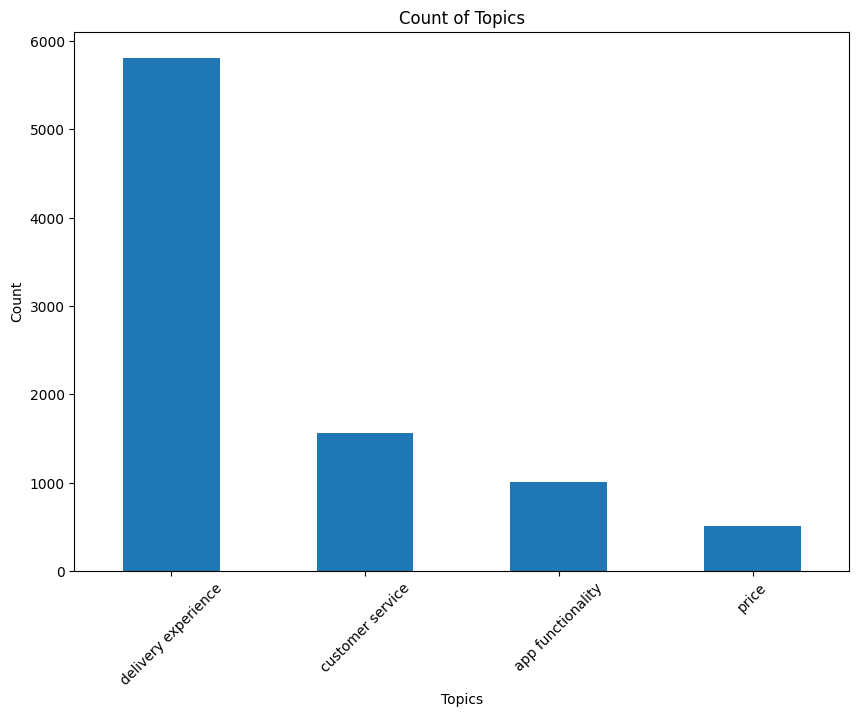

In [22]:
# Count the number of each sentiment
cluster_topic_counts = df['cluster_topic'].value_counts()

# Plot bar chart
cluster_topic_counts.plot(kind='bar', figsize=(10,7))

plt.title('Count of Topics')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The analysis utilized K-means clustering with a predetermined keywords dictionary to categorize reviews into topics. Each cluster was assigned to the topic with the highest similarity to its centroid based on cosine similarity with keyword vectors. The resulting clusters were mapped to specific topics such as "customer service" and "app functionality."

Findings revealed distinct topic distributions within the dataset, with certain topics appearing more frequently than others. For instance, "customer service" emerged as a prominent theme, indicating its significance in user experiences. The visualization of topic counts illustrated the prevalence of each theme, providing insights into the underlying patterns of user feedback. This approach offers a structured method for uncovering meaningful topics in large datasets, facilitating deeper insights into customer sentiments and preferences.

## Keyword-driven Unsupervised Topic Analysis with DBSCAN

In [23]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

# Calculate similarity between cluster centroids and keyword vectors
centroid_similarities = cosine_similarity(X[dbscan.core_sample_indices_], vectorizer.transform(keyword_texts))

# Assign each cluster to the topic with the highest similarity
cluster_topics = {i: list(keywords_dict.keys())[np.argmax(centroid_similarities[i])] for i in range(len(dbscan.core_sample_indices_))}

# Map reviews to cluster topics
df['dbscan_cluster_topic'] = [cluster_topics[label] if label != -1 else 'Noise' for label in dbscan.labels_[:len(df)]]

# Output DataFrame
print(df[['cleaned_text', 'dbscan_cluster_topic']])

                                           cleaned_text dbscan_cluster_topic
0     ['lately', 'common', 'wait', 'hour', 'food', '...                Noise
1     ['love', 'great', 'offer', 'good', 'selection'...                Noise
2     ['disappointed', 'app', 'used', 'long', 'time'...                Noise
3     ['fairly', 'easy', 'use', 'trying', 'find', 'h...                Noise
4     ['like', 'fact', 'u', 'ca', 'get', 'refund', '...                Noise
...                                                 ...                  ...
8892  ['food', 'good', 'delivery', 'took', 'forever'...                Noise
8893  ['whenever', 'never', 'sent', 'correct', 'item...                Noise
8894  ['delivery', 'driver', 'turn', 'incorrect', 'l...                Noise
8895  ['great', 'deal', 'buddy', 'pizza', 'buy', 'on...                Noise
8896  ['prompt', 'service', 'excellent', 'communicat...                Noise

[8897 rows x 2 columns]


In [24]:
df.head()

,stars,cleaned_text,sentiment,cleaned_text_list,cleaned_text_str,cluster,cluster_topic,dbscan_cluster_topic
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative,"[lately, common, wait, hour, food, passed, dri...",lately common wait hour food passed driver one...,-1,delivery experience,Noise
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive,"[love, great, offer, good, selection, food, sh...",love great offer good selection food shopping ...,-1,app functionality,Noise
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative,"[disappointed, app, used, long, time, service,...",disappointed app used long time service fee ke...,-1,price,Noise
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative,"[fairly, easy, use, trying, find, happening, c...",fairly easy use trying find happening contacti...,-1,delivery experience,Noise
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive,"[like, fact, u, ca, get, refund, unless, u, ta...",like fact u ca get refund unless u take pictur...,-1,delivery experience,Noise


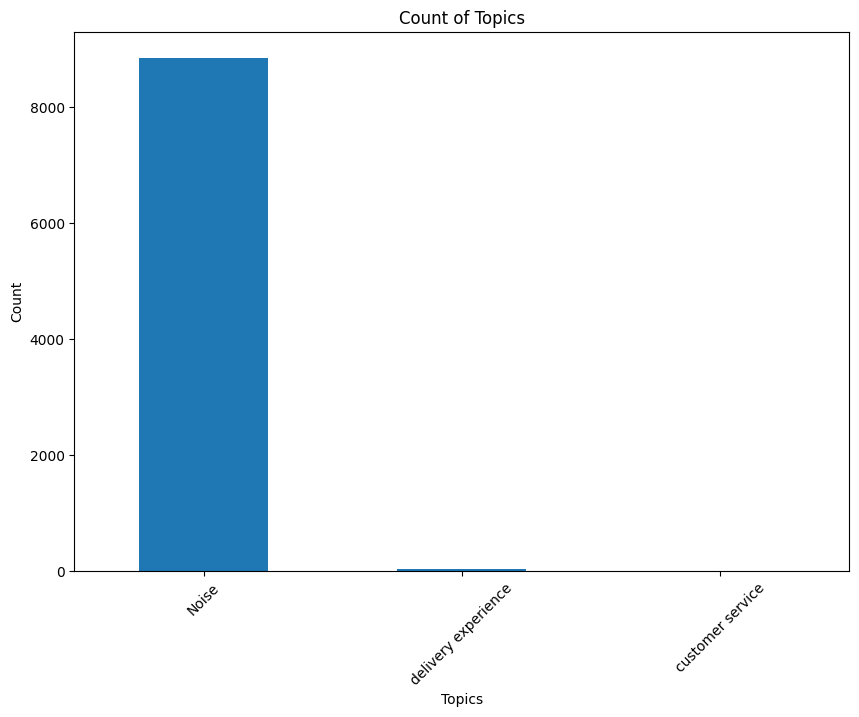

In [25]:
# Count the number of each sentiment
cluster_topic_counts = df['dbscan_cluster_topic'].value_counts()

# Plot bar chart
cluster_topic_counts.plot(kind='bar', figsize=(10,7))

plt.title('Count of Topics')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Similarly as the above , The DBSCAN clustering method was applied to categorize reviews into clusters based on their similarity. However, the silhouette score, which measures the compactness and separation of clusters, was negative (-0.029), indicating poor clustering performance.

Additionally, the majority of data points were labeled as noise (-1), indicating that DBSCAN failed to identify meaningful clusters within the dataset. This suggests that the algorithm struggled to discern distinct patterns or groups among the reviews.

Furthermore, when attempting to assign cluster topics based on the highest similarity to centroid vectors, the resulting topics were predominantly labeled as "Noise," indicating the lack of coherent clusters.

Overall, the DBSCAN clustering approach did not yield meaningful results or discernible patterns within the dataset, highlighting its limitations in handling this particular dataset for sentiment analysis.

# 5. Conclusion <a id='Conclusion'></a>
[Back to top](#table_of_contents)

In conclusion, the K-means clustering algorithm and DBSCAN algorithm were both employed to perform sentiment analysis on a dataset of reviews.

K-means clustering demonstrated moderate success in identifying clusters, as evidenced by a positive silhouette score and the formation of distinct clusters. The analysis revealed meaningful insights into the topics discussed in the reviews, allowing for a nuanced understanding of customer sentiments.

On the other hand, DBSCAN exhibited limitations in effectively clustering the data. With a negative silhouette score and the majority of points labeled as noise, DBSCAN struggled to identify coherent clusters. Consequently, the assigned topics were predominantly labeled as "Noise," indicating a lack of meaningful structure in the data.

Overall, while K-means clustering provided valuable insights into sentiment patterns, DBSCAN's performance was hindered by its inability to discern meaningful clusters, highlighting the importance of selecting an appropriate clustering algorithm based on the characteristics of the dataset.